In [1]:
from sqlalchemy import create_engine
import pandas as pd
import datetime
from sklearn.tree import DecisionTreeRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import matplotlib as mpl
import numpy as np
from sklearn.tree import export_graphviz 
import pickle
import matplotlib.pyplot as plt

mpl.rcParams['agg.path.chunksize'] = 1000000

dbuser = "dublinbikes"
dbpw = "dublin_bikes1"
dbname="dublinbikes"
dbhost = "dublinbikes.cigavyhinuih.eu-west-1.rds.amazonaws.com"

In [93]:
def make_engine():
    engine = create_engine("mysql+mysqlconnector://{}:{}@{}:{}/{}".format(dbuser, dbpw, dbhost, 3306,  dbname))
    return engine 

def get_historical_availability(engine):
    query = '''select * from historicalstationdata where stationnumber!=507'''
    df = pd.read_sql(query, engine)
    return df

def get_historical_weather(engine):
    query = '''select * from weathercurrent''' 
    df = pd.read_sql(query, engine) 
    return df 

def add_availability_features(raw_data):
    
    """Adds some new columns for the model - the target variable which will be the % of bikes available, 
    the day of the week, and the hour in the day.
    
    Removes columns that will not be used.""" 
    
    raw_data['%available'] = raw_data['availablebikes']/raw_data['bikestands'] 
    
    raw_data['Hour'] = raw_data['updatetime'].apply(lambda x: str(x.hour))#.astype('category')
    
    raw_data['Weekday'] = raw_data['updatetime'].apply(lambda x: str(x.weekday()))#.astype('category')
    
    raw_data['stationnumber'] = raw_data['stationnumber'].astype('category')
    
    raw_data = raw_data.sort_values(by='updatetime', ascending=True)
    
    raw_data = raw_data[['updatetime','stationnumber', '%available', 'Hour', 'Weekday']].dropna(how='any').reset_index(drop=True) 
    
    return raw_data

def add_weather_features(raw_data):
    
    """Adds an updatetime field as a datetime object for merging with the availability data"""
    
    raw_data['updatetime'] = raw_data['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x)) 
    
    raw_data = raw_data.sort_values(by='updatetime', ascending=True) 
    
    raw_data['detail'] = raw_data['detail'].astype('category')
    
    raw_data = raw_data[['updatetime','temp','feelslike','wind','detail','weather','humidity']].dropna(how='any').reset_index(drop=True)
    
    return raw_data

In [63]:
ENGINE = make_engine()

In [94]:
#LOAD THE RAW DATA
availability_data = get_historical_availability(ENGINE) 
weather_data = get_historical_weather(ENGINE) 

print(len(availability_data)) 
print(len(weather_data))

967020
7224


In [95]:
#CLEANUP AND CREATE FEATURES
availability_data = add_availability_features(availability_data)  
weather_data = add_weather_features(weather_data)

In [104]:
#MERGE THE AVAILABILITY AND THE WEATHER DATA 
full_dataset = pd.merge_asof(availability_data, weather_data, on='updatetime', direction='nearest', tolerance=datetime.timedelta(minutes=20)) 
full_dataset = full_dataset.dropna(how='any').reset_index(drop=True) 

In [105]:
full_dataset.dtypes

updatetime       datetime64[ns]
stationnumber          category
%available              float64
Hour                     object
Weekday                  object
temp                    float64
feelslike               float64
wind                    float64
detail                 category
weather                  object
humidity                float64
dtype: object

In [98]:
all_stations = list(set(full_dataset['stationnumber'])) 

max_volatility = 0
max_volatility_station = None

for station in all_stations:
    
    volatility = np.std(full_dataset[full_dataset['stationnumber']==station]['%available'])
   
    if volatility>max_volatility:
        
        max_volatility = volatility 
        
        max_volatility_station = station 
        
        
print("The station with the maximum volatility is " + str(max_volatility_station))


The station with the maximum volatility is 31


In [106]:
full_dataset.head()

,updatetime,stationnumber,%available,Hour,Weekday,temp,feelslike,wind,detail,weather,humidity
0,2021-02-18 20:58:48,48,0.225000,20,3,5.44,-0.66,6.17,scattered clouds,Clouds,75.0
1,2021-02-18 20:58:48,99,0.233333,20,3,5.44,-0.66,6.17,scattered clouds,Clouds,75.0
2,2021-02-18 20:58:48,37,0.033333,20,3,5.44,-0.66,6.17,scattered clouds,Clouds,75.0
3,2021-02-18 20:58:48,69,0.675000,20,3,5.44,-0.66,6.17,scattered clouds,Clouds,75.0
4,2021-02-18 20:58:48,92,0.525000,20,3,5.44,-0.66,6.17,scattered clouds,Clouds,75.0


In [107]:
chosen_station_data = full_dataset[full_dataset['stationnumber']==31]

<AxesSubplot:title={'center':'Weekday & % Bikes Available'}, xlabel='Weekday'>

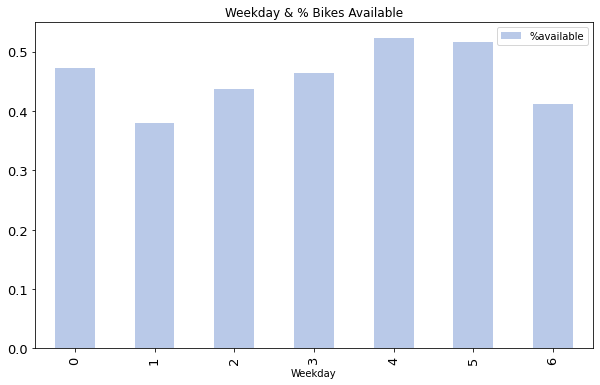

In [68]:
day_of_week = chosen_station_data[['Weekday', '%available']].groupby(by='Weekday').mean() 
day_of_week.plot(kind='bar', figsize=(10,6), color=(0.1, 0.3, 0.7, 0.3), fontsize=13, title="Weekday & % Bikes Available")


<ipython-input-72-9646d2471d9c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hour_of_day['Hour'] = hour_of_day['Hour'].astype('int32')


<AxesSubplot:title={'center':'Hour in Day & % Bikes Available'}, xlabel='Hour'>

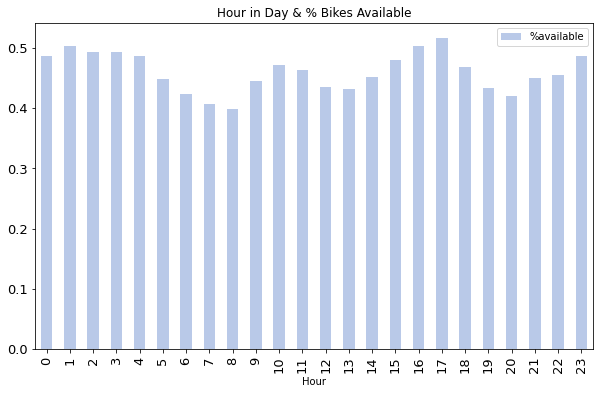

In [72]:
hour_of_day = chosen_station_data[['Hour', '%available']]
hour_of_day['Hour'] = hour_of_day['Hour'].astype('int32')
hour_of_day = hour_of_day.groupby(by='Hour').mean() 
hour_of_day.plot(kind='bar', figsize=(10,6), color=(0.1, 0.3, 0.7, 0.3), fontsize=13, title="Hour in Day & % Bikes Available")



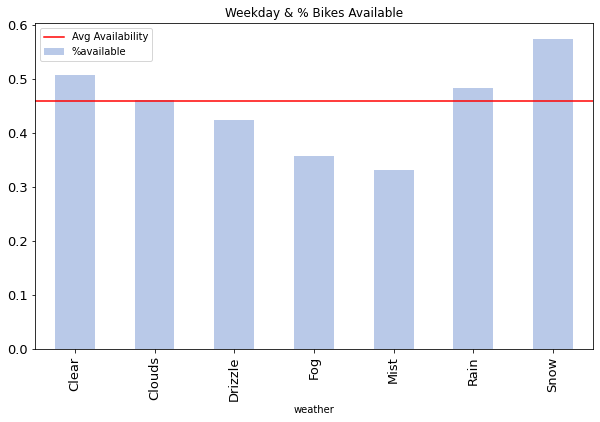

In [112]:
day_of_week = chosen_station_data[['weather', '%available']].groupby(by='weather').mean() 
day_of_week.plot(kind='bar', figsize=(10,6), color=(0.1, 0.3, 0.7, 0.3), fontsize=13, title="Weekday & % Bikes Available")


avg_available = sum(chosen_station_data['%available'])/len(chosen_station_data)
plt.axhline(y=avg_available, color='r', linestyle='-', label="Avg Availability")
plt.legend()

-0.06429800274100929

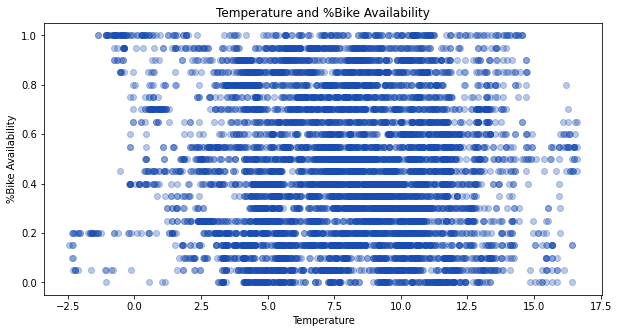

In [81]:
plt.figure(figsize=(10, 5))
plt.plot(chosen_station_data['temp'], chosen_station_data['%available'], 'o', color=(0.1, 0.3, 0.7, 0.3)) 
plt.title("Temperature and %Bike Availability")
plt.ylabel("%Bike Availability") 
plt.xlabel("Temperature")
np.corrcoef(chosen_station_data['temp'], chosen_station_data['%available'])[0, 1]

-0.05139303871203082

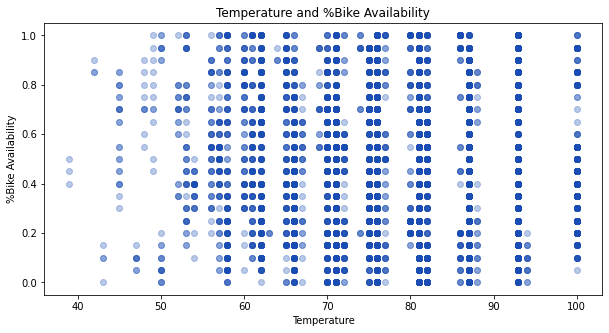

In [85]:
plt.figure(figsize=(10, 5))
plt.plot(chosen_station_data['humidity'], chosen_station_data['%available'], 'o', color=(0.1, 0.3, 0.7, 0.3)) 
plt.title("Temperature and %Bike Availability")
plt.ylabel("%Bike Availability") 
plt.xlabel("Temperature")
np.corrcoef(chosen_station_data['feelslike'], chosen_station_data['%available'])[0, 1]

In [119]:
#one-hot encoding the weather detail as  numeric
full_dataset['light_rain'] = full_dataset['weather'].apply(lambda x: 1 if x in ['Drizzle', 'Fog', 'Mist'] else 0) 
full_dataset['rain'] = full_dataset['weather'].apply(lambda x: 1 if x in ['Rain', 'Snow'] else 0) 
full_dataset['clear'] = full_dataset['weather'].apply(lambda x: 1 if x in ['Clear', 'Clouds'] else 0) 

In [120]:
PREDICT_COLUMNS = ['Hour', 'Weekday', 'light_rain', 'rain', 'clear']

<font size=5>Decision Tree Model Evaluation</b>

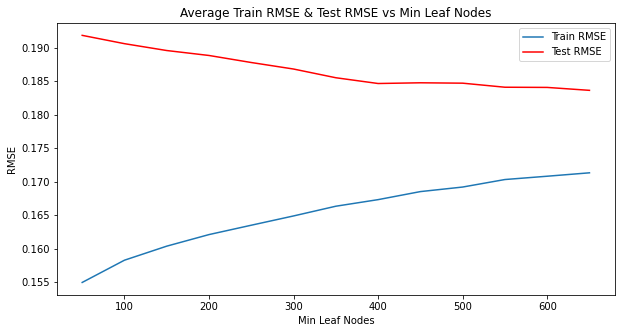

In [122]:
def dt_model_constructor(raw_data, station_number, min_leaf): 
    
    station_data = raw_data[raw_data['stationnumber']==station_number]  
    
    #use 80% of the data for training
    train_data = station_data.head(int(0.8*len(station_data)))
    
    #use 20% of the data for testing
    test_data = station_data.tail(int(0.2*len(station_data)))
    
    x_train = train_data[PREDICT_COLUMNS].values
    
    y_train = train_data[[target_column]].values  
    
    x_test = test_data[PREDICT_COLUMNS].values
    
    y_test = test_data[[target_column]].values  
    
    model = DecisionTreeRegressor(random_state=0, min_samples_leaf=min_leaf)
    
    model.fit(x_train, y_train)  
    predicted_train = model.predict(x_train) 
    observed_train = y_train.reshape((y_train.shape[0],))
    r2_train = round(np.corrcoef(predicted_train, observed_train)[0, 1]**2, 3)  
    MAE_train = sum(abs(predicted_train-observed_train))/len(observed_train) 
    RMSE_train = np.sqrt(np.mean((predicted_train-observed_train)**2)) 
    
    predicted_test = model.predict(x_test) 
    observed_test = y_test.reshape((y_test.shape[0],))
    r2_test = round(np.corrcoef(predicted_test, observed_test)[0, 1]**2, 3)  
    MAE_test = sum(abs(predicted_test-observed_test))/len(observed_test) 
    RMSE_test = np.sqrt(np.mean((predicted_test-observed_test)**2)) 
    
    station_evaluation_metrics['StationNumber'].append(station_number) 
    station_evaluation_metrics['r2_train'].append(r2_train) 
    station_evaluation_metrics['mae_train'].append(MAE_train)
    station_evaluation_metrics['rmse_train'].append(RMSE_train)
    station_evaluation_metrics['r2_test'].append(r2_test) 
    station_evaluation_metrics['mae_test'].append(MAE_test)
    station_evaluation_metrics['rmse_test'].append(RMSE_test)
    

min_leaf_nodes = [] 
avg_train_rmse = []
avg_test_rmse = []

for min_leaf_node in range(50, 700, 50):
    
    station_models = {}

    station_evaluation_metrics = {'StationNumber':[], 'r2_train':[], 'mae_train':[], 'rmse_train':[], 'r2_test':[],
                             'mae_test':[], 'rmse_test':[]}  

    target_column = "%available" 
    
    for station in list(set(full_dataset['stationnumber'])):
        
        dt_model_constructor(full_dataset, station, min_leaf = min_leaf_node) 
        
    average_train_rmse = sum(station_evaluation_metrics['rmse_train'])/len(station_evaluation_metrics['rmse_train'])
    
    average_test_rmse = sum(station_evaluation_metrics['rmse_test'])/len(station_evaluation_metrics['rmse_test'])
    

    min_leaf_nodes.append(min_leaf_node) 
    avg_train_rmse.append(average_train_rmse) 
    avg_test_rmse.append(average_test_rmse) 

plt.figure(figsize=(10, 5))
plt.title("Average Train RMSE & Test RMSE vs Min Leaf Nodes")
plt.ylabel("RMSE") 
plt.xlabel("Min Leaf Nodes")
plt.plot(min_leaf_nodes, avg_train_rmse, label="Train RMSE") 
plt.plot(min_leaf_nodes, avg_test_rmse, label="Test RMSE", color="red") 
plt.legend()



<font size=5>KNN Model Evaluation</b>

In [ ]:
def knn_model_constructor(raw_data, station_number, n_neighbours): 
    
    station_data = raw_data[raw_data['stationnumber']==station_number]  
    
    #use 80% of the data for training
    train_data = station_data.head(int(0.8*len(station_data)))
    
    #use 20% of the data for testing
    test_data = station_data.tail(int(0.2*len(station_data)))
    
    x_train = train_data[PREDICT_COLUMNS].values
    
    y_train = train_data[[target_column]].values  
    
    x_test = test_data[PREDICT_COLUMNS].values
    
    y_test = test_data[[target_column]].values  
    
    model = KNeighborsRegressor(n_neighbors=n_neighbours)
    
    model.fit(x_train, y_train)  
    predicted_train = model.predict(x_train)  
    
    predicted_train = predicted_train.reshape((predicted_train.shape[0],))
    observed_train = y_train.reshape((y_train.shape[0],)) 
    
   
    r2_train = round(np.corrcoef(predicted_train, observed_train)[0, 1]**2, 3)  
    MAE_train = sum(abs(predicted_train-observed_train))/len(observed_train) 
    RMSE_train = np.sqrt(np.mean((predicted_train-observed_train)**2)) 
    
    predicted_test = model.predict(x_test) 
    predicted_test = predicted_test.reshape((predicted_test.shape[0],))
    observed_test = y_test.reshape((y_test.shape[0],))
    r2_test = round(np.corrcoef(predicted_test, observed_test)[0, 1]**2, 3)  
    MAE_test = sum(abs(predicted_test-observed_test))/len(observed_test) 
    RMSE_test = np.sqrt(np.mean((predicted_test-observed_test)**2)) 
    
    station_evaluation_metrics['StationNumber'].append(station_number) 
    station_evaluation_metrics['r2_train'].append(r2_train) 
    station_evaluation_metrics['mae_train'].append(MAE_train)
    station_evaluation_metrics['rmse_train'].append(RMSE_train)
    station_evaluation_metrics['r2_test'].append(r2_test) 
    station_evaluation_metrics['mae_test'].append(MAE_test)
    station_evaluation_metrics['rmse_test'].append(RMSE_test)
    

nearest_neighbours = [] 
avg_train_rmse = []
avg_test_rmse = []

for num_neighbours in range(3, 50):
    print(num_neighbours)
    
    station_models = {}

    station_evaluation_metrics = {'StationNumber':[], 'r2_train':[], 'mae_train':[], 'rmse_train':[], 'r2_test':[],
                             'mae_test':[], 'rmse_test':[]} 

    predict_columns = ['stationnumber','Hour','Weekday','temp','feelslike','wind','humidity']  

    target_column = "%available"  
    
    full_dataset['Hour'] = full_dataset['Hour'].apply(float) 
    
    full_dataset['Weekday'] = full_dataset['Weekday'].apply(float) 
    
    for station in list(set(full_dataset['stationnumber'])):
        
        knn_model_constructor(full_dataset, station, num_neighbours) 
        
    average_train_rmse = sum(station_evaluation_metrics['rmse_train'])/len(station_evaluation_metrics['rmse_train'])
    
    average_test_rmse = sum(station_evaluation_metrics['rmse_test'])/len(station_evaluation_metrics['rmse_test'])
    

    nearest_neighbours.append(num_neighbours) 
    avg_train_rmse.append(average_train_rmse) 
    avg_test_rmse.append(average_test_rmse) 

plt.figure(figsize=(10, 5))
plt.title("Train RMSE & Test RMSE vs Num Neighbours")
plt.ylabel("RMSE")
plt.xlabel("Num Neighbours")
plt.plot(nearest_neighbours, avg_train_rmse, label="Train RMSE") 
plt.plot(nearest_neighbours, avg_test_rmse, label="Test RMSE", color="red") 
plt.legend()




3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


<font size=5>Decision Tree</font></b>

In [215]:
#SET THE X VALUES AND Y VALUES AS NUMPY ARRAYS TO BE PROCESSED BY THE MODEL
predict_columns = ['stationnumber','Hour','Weekday','temp','feelslike','wind','humidity'] 

with open('feature_list.pkl','wb') as f:
    pickle.dump(predict_columns, f)

target_column = '%available' 

x_values = train_set[predict_columns].values
y_values = train_set[[target_column]].values

In [212]:
#FIT THE MODEL
model = DecisionTreeRegressor(random_state=0, min_samples_leaf=500)
model.fit(x_values, y_values) 



DecisionTreeRegressor(min_samples_leaf=500, random_state=0)

R2: 0.407
Average Error 13.55%


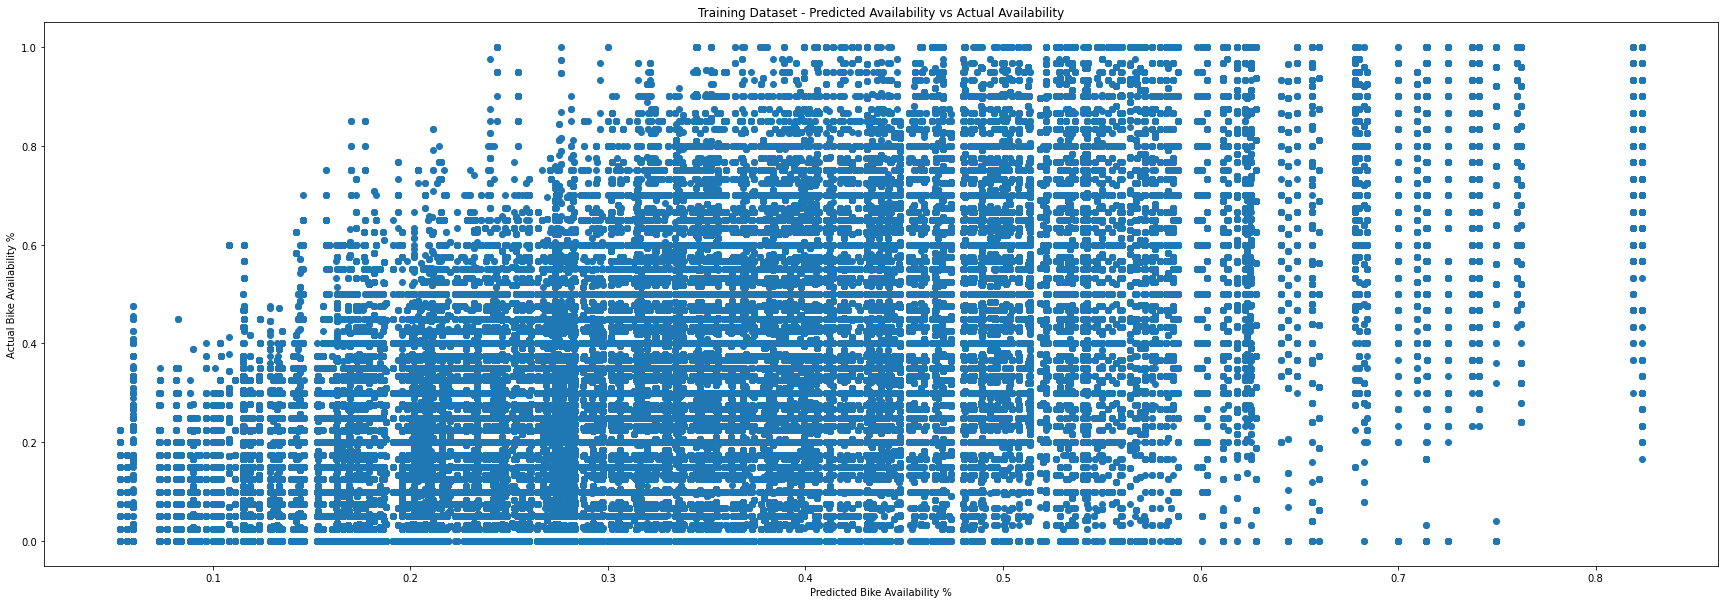

In [182]:
#PERFORMANCE ON THE TRAINING DATASET
plt.figure(figsize=(30, 10))
plt.title('Training Dataset - Predicted Availability vs Actual Availability') 
plt.xlabel("Predicted Bike Availability %")
plt.ylabel("Actual Bike Availability %")

predictions = model.predict(x_values)
y_values = y_values.reshape((y_values.shape[0],)) 

print("R2:",round(np.corrcoef(predictions, y_values)[0, 1]**2, 3))

print("Average Error", str(round(100*sum(abs(predictions-y_values))/len(y_values),2))+'%')
mpl.pyplot.plot(predictions, y_values, linestyle="None", marker='o') 


R2: 0.406
Average Error 13.59%


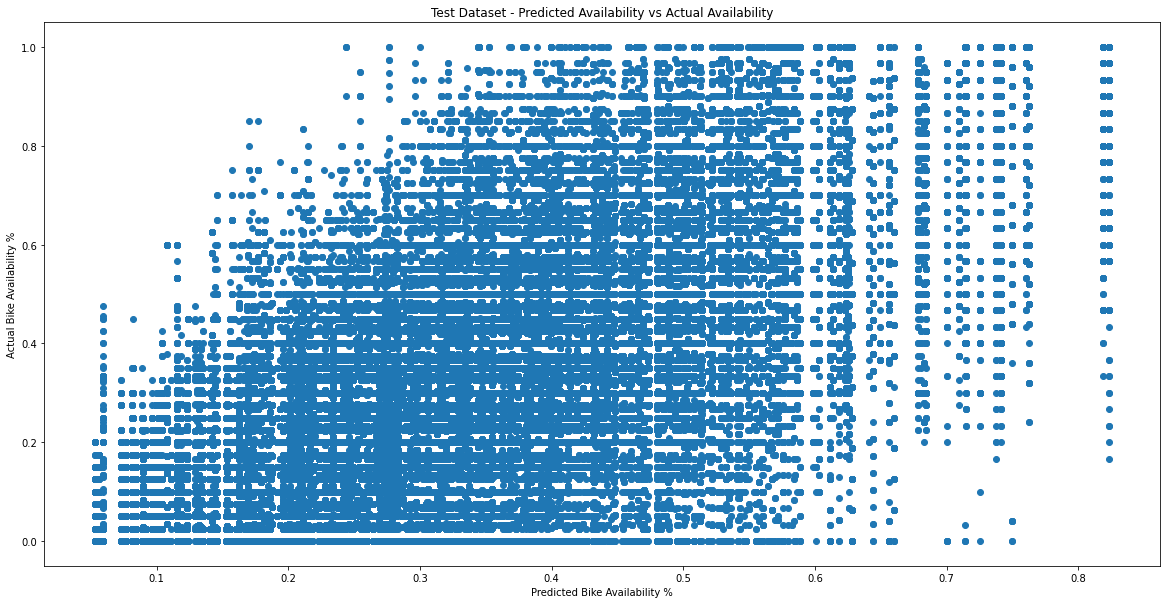

In [196]:
#MODEL PERFORMANCE ON THE TEST SET

plt.figure(figsize=(20, 10))
plt.title('Test Dataset - Predicted Availability vs Actual Availability') 
plt.xlabel("Predicted Bike Availability %")
plt.ylabel("Actual Bike Availability %")


test_set_x_values = test_set[predict_columns].values
test_set_y_values = test_set[[target_column]].values 

test_predictions = model.predict(test_set_x_values)
test_set_y_values = test_set_y_values.reshape((test_set_y_values.shape[0],)) 

print("R2:",round(np.corrcoef(test_predictions, test_set_y_values)[0, 1]**2, 3))

print("Average Error", str(round(100*sum(abs(test_predictions-test_set_y_values))/len(test_set_y_values),2))+'%')
mpl.pyplot.plot(test_predictions, test_set_y_values, linestyle="None", marker='o') 

In [214]:
pickle.dump(model, open("decision_tree_model.sav", 'wb'))

<font size=5>Linear Regression</font></b>

In [146]:
model = linear_model.LinearRegression() 

predict_columns = ['stationnumber','Hour','Weekday','temp','feelslike','wind','humidity'] 
target_column = '%available' 

x_values = train_set[predict_columns].values
y_values = train_set[[target_column]].values

In [147]:
model.fit(x_values, y_values)

LinearRegression()

R2: 0.003
Average Error 17.93%


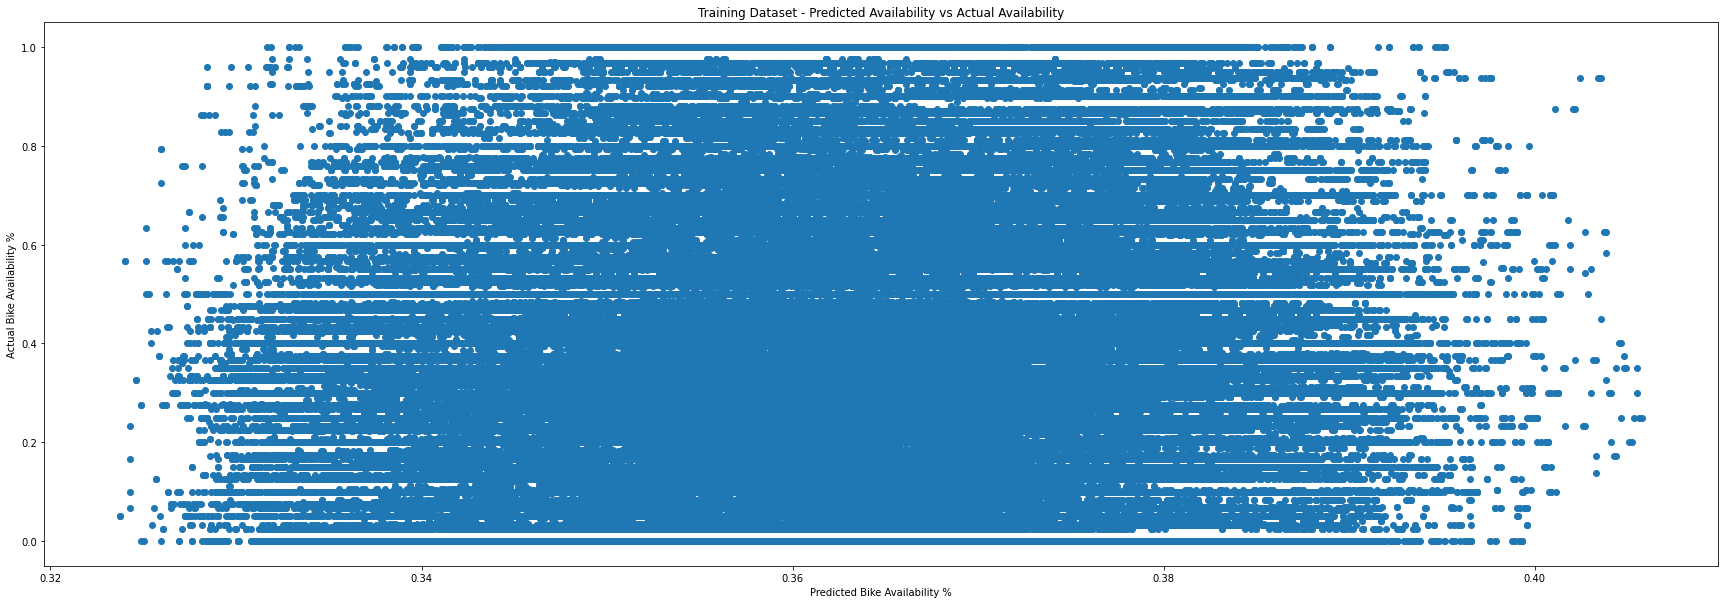

In [151]:
plt.figure(figsize=(30, 10))
plt.title('Training Dataset - Predicted Availability vs Actual Availability') 
plt.xlabel("Predicted Bike Availability %")
plt.ylabel("Actual Bike Availability %")

predictions = model.predict(x_values)

predictions = predictions.reshape((predictions.shape[0],))  
y_values = y_values.reshape((y_values.shape[0],))  

print("R2:",round(np.corrcoef(predictions, y_values)[0, 1]**2, 3))

print("Average Error", str(round(100*sum(abs(predictions-y_values))/len(y_values),2))+'%')
mpl.pyplot.plot(predictions, y_values, linestyle="None", marker='o') 

R2: 0.0
Average Error 19.03%


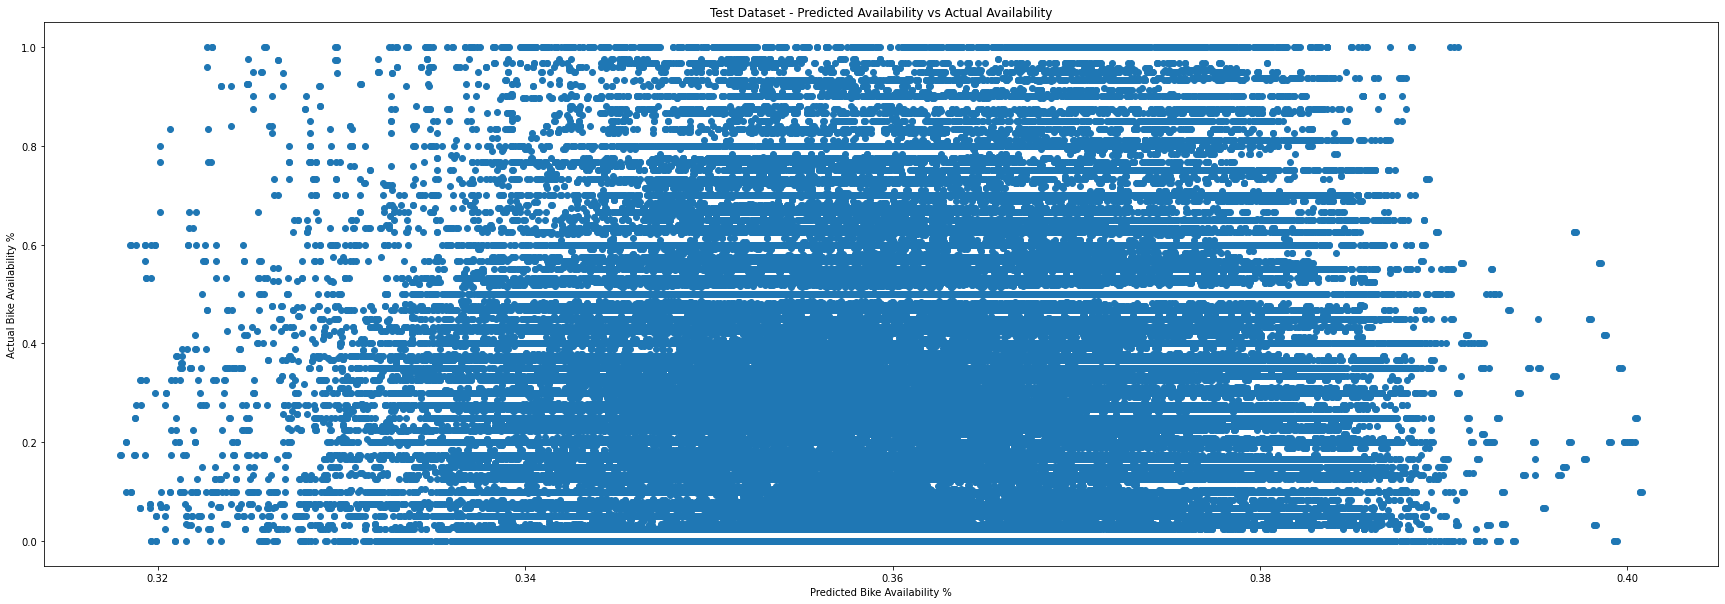

In [153]:
#MODEL PERFORMANCE ON THE TEST SET

plt.figure(figsize=(30, 10))
plt.title('Test Dataset - Predicted Availability vs Actual Availability') 
plt.xlabel("Predicted Bike Availability %")
plt.ylabel("Actual Bike Availability %")


test_set_x_values = test_set[predict_columns].values
test_set_y_values = test_set[[target_column]].values 

test_predictions = model.predict(test_set_x_values) 

test_predictions = test_predictions.reshape((test_predictions.shape[0],)) 
test_set_y_values = test_set_y_values.reshape((test_set_y_values.shape[0],)) 


print("R2:",round(np.corrcoef(test_predictions, test_set_y_values)[0, 1]**2, 3))

print("Average Error", str(round(100*sum(abs(test_predictions-test_set_y_values))/len(test_set_y_values),2))+'%')
mpl.pyplot.plot(test_predictions, test_set_y_values, linestyle="None", marker='o') 